# distilbert-base-uncased

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification
import pandas as pd
import thesis_utils
from datasets import Dataset
from datasets import Sequence, ClassLabel, Features, Value
from evaluate import load
import random
import numpy as np
import csv
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support

/home/elisabetta/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
comet_ml is installed but `COMET_API_KEY` is not set.


In [4]:
import warnings
warnings.filterwarnings("ignore", message=".*seems not to be NE tag.*")

### Loading the model

In [6]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/elisabetta/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
task = "GED"
batch_size = 16

### Preprocessing

In [9]:
multiged_fce_train =  thesis_utils.read_tsv_file_and_find_sentences_without_headers('./MULTI-GED2023 DATA/en_fce_train.tsv')
multiged_fce_dev =  thesis_utils.read_tsv_file_and_find_sentences_without_headers('./MULTI-GED2023 DATA/en_fce_dev.tsv')

multiged_realec_dev=  thesis_utils.read_tsv_file_and_find_sentences_without_headers('./MULTI-GED2023 DATA/en_realec_dev.tsv')

processed_fce = thesis_utils.read_tsv_file_and_find_sentences_with_headers('./processed_fce.tsv')
processed_realec = thesis_utils.read_tsv_file_and_find_sentences_with_headers('./processed_realec.tsv')

In [10]:
print(f'Number of training sentences: {len(multiged_fce_train)}')
print(f'Number of dev (FCE) sentences: {len(multiged_fce_dev)}')
print(f'Number of dev (REALEC) sentences: {len(multiged_realec_dev)}')
print(f'Number of processed dev (FCE) sentences: {len(processed_fce)}')
print(f'Number of processed dev (REALEC) sentences: {len(processed_realec)}\n')

print(f'Number of training tokens: {thesis_utils.token_counter(multiged_fce_train)}')
print(f'Number of dev tokens (FCE): {thesis_utils.token_counter(multiged_fce_dev)}')
print(f'Number of dev tokens (REALEC): {thesis_utils.token_counter(multiged_realec_dev)}')
print(f'Number of processed dev (FCE) tokens: {thesis_utils.token_counter(processed_fce)}')
print(f'Number of processed dev (REALEC) tokens: {thesis_utils.token_counter(processed_realec)}')

Number of training sentences: 28357
Number of dev (FCE) sentences: 2191
Number of dev (REALEC) sentences: 4067
Number of processed dev (FCE) sentences: 2187
Number of processed dev (REALEC) sentences: 4015

Number of training tokens: 454730
Number of dev tokens (FCE): 34748
Number of dev tokens (REALEC): 88008
Number of processed dev (FCE) tokens: 34703
Number of processed dev (REALEC) tokens: 86362


In [11]:
multiged_labels = ['c','i']
training_sents_idx, training_sents_tokens, training_sents_gold = thesis_utils.get_list_ids_tokens_gold_finetuning(multiged_fce_train, False)
proc_fce_sents_idx, proc_fce_sents_tokens, proc_fce_labels = thesis_utils.get_list_ids_tokens_gold_finetuning(processed_fce, True)
proc_realec_sents_idx, proc_realec_sents_tokens, proc_realec_labels = thesis_utils.get_list_ids_tokens_gold_finetuning(processed_realec, True)

In [12]:
training_list_dict = thesis_utils.create_list_dict(training_sents_idx, training_sents_tokens, training_sents_gold)
processed_fce_dict = thesis_utils.create_list_dict(proc_fce_sents_idx, proc_fce_sents_tokens, proc_fce_labels)
processed_realec_dict = thesis_utils.create_list_dict(proc_realec_sents_idx, proc_realec_sents_tokens, proc_realec_labels)

In [13]:
training_df = pd.DataFrame(training_list_dict)
training_dataset = Dataset.from_pandas(training_df)

proc_fce_df = pd.DataFrame(processed_fce_dict)
proc_fce_dataset = Dataset.from_pandas(proc_fce_df)

proc_realec_df = pd.DataFrame(processed_realec_dict)
proc_realec_dataset =  Dataset.from_pandas(proc_realec_df)

In [14]:
new_features = Features({
    "id_token": Sequence(Value("int64")),
    "token": Sequence(Value("string")),
    "labels": Sequence(ClassLabel(names=multiged_labels)),
})

training_dataset = training_dataset.cast(new_features)
proc_fce_dataset = proc_fce_dataset.cast(new_features)
proc_realec_dataset = proc_realec_dataset.cast(new_features)

Casting the dataset:   0%|          | 0/28357 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2187 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4015 [00:00<?, ? examples/s]

In [15]:
label_all_tokens = True

def tokenize_and_align_labels(dataset):
    tokenized_inputs = tokenizer(dataset["token"], truncation=True, is_split_into_words=True)
    labels = []
    tokenized_ids = []
    for i, label in enumerate(dataset["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
        tokenized_ids.append(word_ids)
    tokenized_inputs["t_word_id"] = tokenized_ids
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [16]:
tokenized_training_dataset = training_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_proc_fce_dataset = proc_fce_dataset.map(tokenize_and_align_labels, batched = True)
tokenized_proc_realec_dataset = proc_realec_dataset.map(tokenize_and_align_labels, batched = True)

Map:   0%|          | 0/28357 [00:00<?, ? examples/s]

Map:   0%|          | 0/2187 [00:00<?, ? examples/s]

Map:   0%|          | 0/4015 [00:00<?, ? examples/s]

In [17]:
SEED = 1234
random.seed(SEED)   
np.random.seed(SEED)  
set_seed(SEED)  

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

/home/elisabetta/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [18]:
tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_ged_bert', use_fast=True)
model = AutoModelForTokenClassification.from_pretrained('./fine_tuned_ged_bert')

data_collator = DataCollatorForTokenClassification(tokenizer)

In [19]:
metric = load("seqeval")

In [20]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [multiged_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [multiged_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

## FCE

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_proc_fce_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [25]:
trainer.evaluate()

/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'eval_loss': 0.21975351870059967,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.9236703207470565,
 'eval_runtime': 62.5259,
 'eval_samples_per_second': 34.978,
 'eval_steps_per_second': 2.191}

In [28]:
predictions, labels, _ = trainer.predict(tokenized_proc_fce_dataset)
predictions = np.argmax(predictions, axis=2)

/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [34]:
output_file_path = './uselessfce2.tsv'
proc_fce_tokens, proc_fce_labels, proc_fce_predictions = thesis_utils.map_predictions_to_words_and_save_to_file_sentence(predictions, labels, tokenized_proc_fce_dataset,output_file_path, multiged_labels,tokenizer)

Results saved to ./uselessfce2.tsv


In [35]:
flat_fce_predictions = [prediction for sentence in proc_fce_predictions for prediction in sentence]
flat_fce_labels = [label for sentence in proc_fce_labels for label in sentence]

In [50]:
thesis_utils.add_predictions_to_tsv_with_empty_lines("processed_fce.tsv",proc_fce_predictions, "proc_fce_distilbert_uncased.tsv")

              precision    recall    f0.5-score    support
c               0.9369    0.981986    0.94558        31254
i               0.7105    0.400696    0.61537        3449

micro avg       0.9242    0.924214    0.92421        34703
macro avg       0.8237    0.691341    0.78048        34703


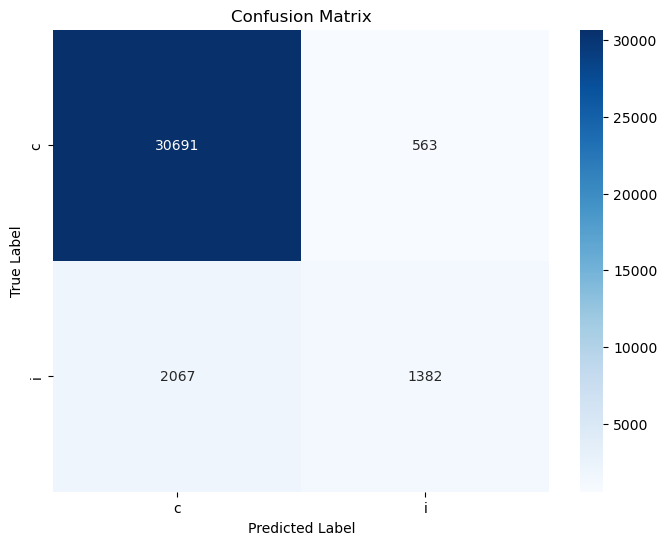

In [36]:
thesis_utils.evaluate_predictions(flat_fce_predictions, flat_fce_labels)

## realec

In [33]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_proc_realec_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [34]:
trainer.evaluate()

/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'eval_loss': 0.3007732331752777,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.9019627236362038,
 'eval_runtime': 155.7016,
 'eval_samples_per_second': 25.787,
 'eval_steps_per_second': 1.612}

In [35]:
predictions, labels, _ = trainer.predict(tokenized_proc_realec_dataset)
predictions = np.argmax(predictions, axis=2)

In [36]:
output_file_path = './uselessrealec2.tsv'
proc_realec_tokens, proc_realec_labels, proc_realec_predictions = thesis_utils.map_predictions_to_words_and_save_to_file_sentence(predictions, labels, tokenized_proc_realec_dataset,output_file_path, multiged_labels,tokenizer)

Results saved to ./uselessrealec2.tsv


In [37]:
flat_realec_predictions = [prediction for sentence in proc_realec_predictions for prediction in sentence]
flat_realec_labels = [label for sentence in proc_realec_labels for label in sentence]

In [38]:
thesis_utils.add_predictions_to_tsv_with_empty_lines("processed_realec.tsv",proc_realec_predictions, "proc_realec_DISbert_UNcased.tsv")

              precision    recall    f0.5-score    support
c               0.9344    0.960945    0.93958        78275
i               0.4785    0.346853    0.44474        8087

micro avg       0.9034    0.903441    0.90344        86362
macro avg       0.7064    0.653899    0.69216        86362


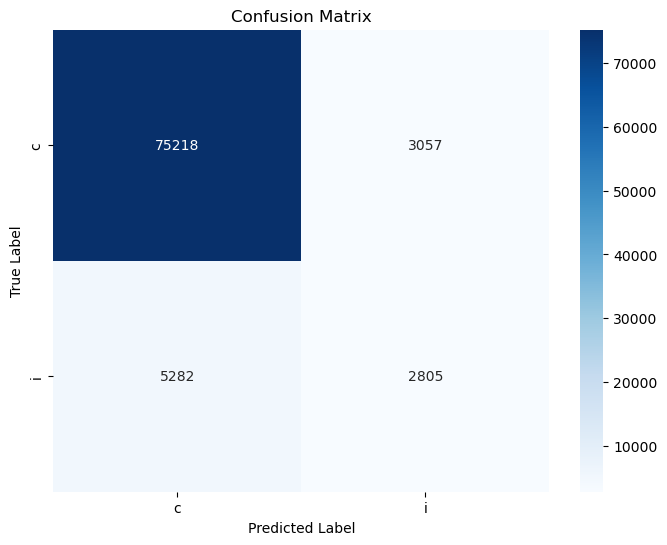

In [39]:
thesis_utils.evaluate_predictions(flat_realec_predictions, flat_realec_labels)